# Introduction

This notebook provides a working minimal example of processing a physiological signal (i.e. raw EEG signal data from a 61 electrode array) and computing complexity measures on the signal.

# Set-Up

## Loading Package Environment

Activating and instantiating Julia environment:

In [1]:
using DrWatson
@quickactivate "JuliaOpenPhysiologicalDSP"

using Pkg
Pkg.instantiate()

Loading required packages:

In [2]:
using CairoMakie 
using ComplexityMeasures 
using CSV
using DSP 
using DataFrames 
using Makie 
using MAT
using TopoPlots

## Defining Some Helper Functions

A function to load `.fdt` files (more information on this type [here](https://eeglab.org/tutorials/ConceptsGuide/Data_Structures.html)):

In [3]:
#=

References for creating this parser come from here:

1. https://sccn.ucsd.edu/wiki/Makoto%27s_useful_EEGLAB_code#How_to_load_EEGLAB_.set_and_.fdt_files_without_using_EEGLAB_.2805.2F09.2F2020_updated.29

=# 
fdt_parser(fdt_file, mat_file) =
    open(fdt_file) do io
        read!(
            io,
            Array{Float32}(undef, (Int(mat_file["nbchan"]), Int(mat_file["pnts"]))),
        )
    end

fdt_parser (generic function with 1 method)

# Loading Data for First Session of Two Subjects

Setting paths to session 1 data for two subjects:

In [4]:
sub_1_ses_1_path = datadir("exp_raw", "sub-01", "ses-1", "eeg")
sub_2_ses_1_path = datadir("exp_raw", "sub-02", "ses-1", "eeg")

"/home/thecedarprince/Knowledgebase/PAPERS/JuliaOpenPhysiologicalDSP/data/exp_raw/sub-02/ses-1/eeg"

Loading data for subjects:

In [5]:
sub_1_mat_file = matread(joinpath(sub_1_ses_1_path, "sub-01_ses-1_task-eyesclosed_eeg.set"))
sub_2_mat_file = matread(joinpath(sub_2_ses_1_path, "sub-02_ses-1_task-eyesclosed_eeg.set"))

sub_1_data = fdt_parser(joinpath(sub_1_ses_1_path, "sub-01_ses-1_task-eyesclosed_eeg.fdt"), sub_1_mat_file)
sub_2_data = fdt_parser(joinpath(sub_2_ses_1_path, "sub-02_ses-1_task-eyesclosed_eeg.fdt"), sub_2_mat_file)

sub_1_electrodes = CSV.read(joinpath(sub_1_ses_1_path, "sub-01_ses-1_electrodes.tsv"), DataFrame)
sub_2_electrodes = CSV.read(joinpath(sub_2_ses_1_path, "sub-02_ses-1_electrodes.tsv"), DataFrame)

61×5 DataFrame
 Row │ name     x           y           z         manufacturer        
     │ String7  Float64     Float64     Float64   String31            
─────┼────────────────────────────────────────────────────────────────
   1 │ Fp1       80.784      26.133      -4.0011  Brain Products GmbH
   2 │ AF3       76.1528     31.4828     20.8468  Brain Products GmbH
   3 │ AF7       68.6911     49.7094     -5.9589  Brain Products GmbH
   4 │ Fz        60.7385      0.0        59.4629  Brain Products GmbH
   5 │ F1        59.9127     26.0421     54.3808  Brain Products GmbH
   6 │ F3        57.5511     48.2004     39.8697  Brain Products GmbH
   7 │ F5        54.0379     63.0582     18.1264  Brain Products GmbH
   8 │ F7        49.8714     68.4233     -7.4895  Brain Products GmbH
   9 │ FC1       32.4362     32.3514     71.5981  Brain Products GmbH
  10 │ FC3       30.9553     59.275      52.4714  Brain Products GmbH
  11 │ FC5       28.7628     76.2474     24.1669  Brain Products GmbH
  ⋮  │    ⋮         ⋮           ⋮          ⋮               ⋮
  52 │ TP8      -26.2848    -80.3851     -8.5057  Brain Products GmbH
  53 │ TP10     -23.3016    -70.0758    -42.0882  Brain Products GmbH
  54 │ P2       -59.8744    -26.0254     54.431   Brain Products GmbH
  55 │ P4       -57.584     -48.1426     39.892   Brain Products GmbH
  56 │ P6       -54.0263    -63.0447     18.2076  Brain Products GmbH
  57 │ P8       -49.9265    -68.3836     -7.4851  Brain Products GmbH
  58 │ POz      -79.0255     -9.68e-15   31.3044  Brain Products GmbH
  59 │ PO4      -76.1528    -31.4828     20.8468  Brain Products GmbH
  60 │ PO8      -68.7209    -49.6689     -5.953   Brain Products GmbH
  61 │ O2       -80.784     -26.133      -4.0011  Brain Products GmbH
                                                       40 rows omitted

# Visualizing Electrode Positions

Creating a general topographic layout of the EEG electrodes for subjects in this dataset:

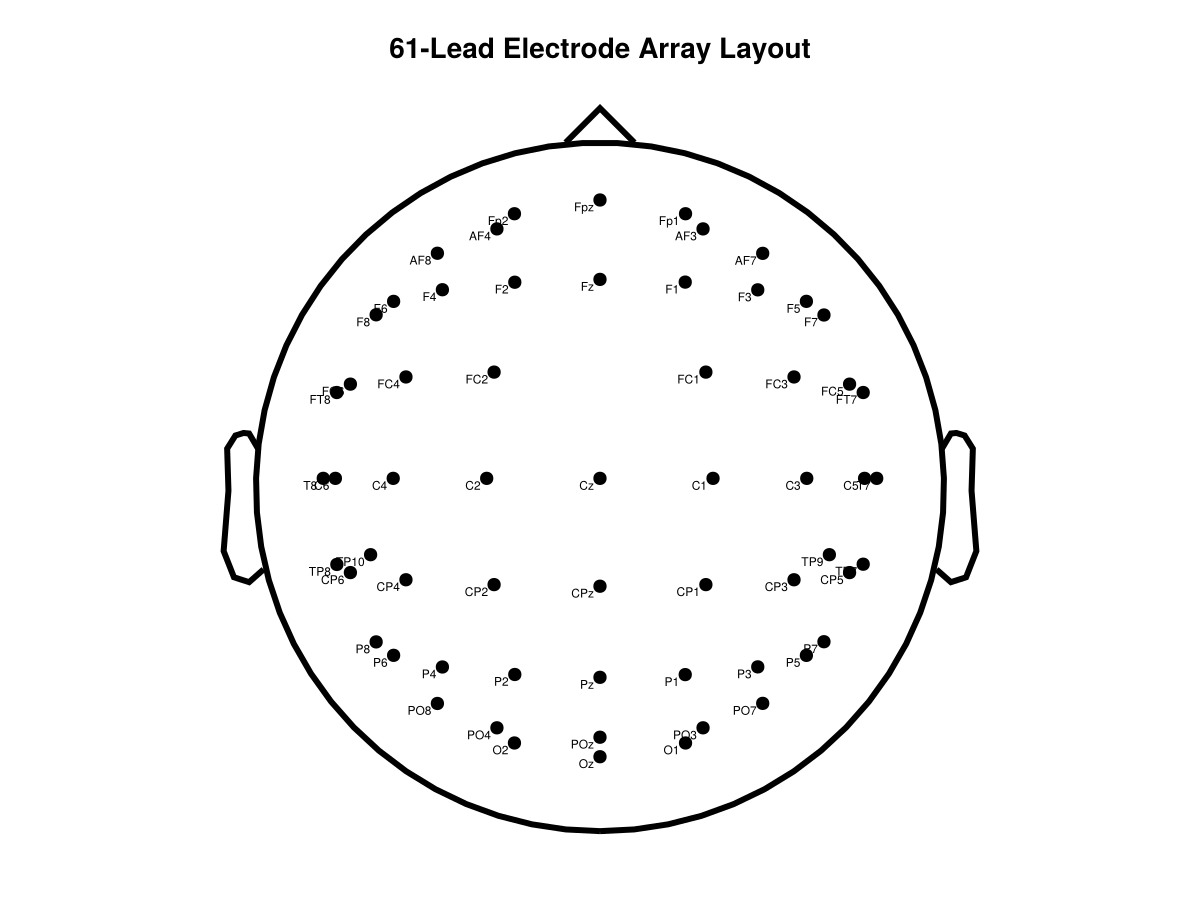

In [6]:
pts = [Point2(sub_1_electrodes.y[i], sub_1_electrodes.x[i]) for i in 1:61]
pts = convert(Vector{Point{2, Float32}}, pts)

fig = eeg_topoplot(
    ones(61), 
    sub_1_electrodes.name, 
    positions = pts, 
    interpolation = NullInterpolator(), 
    label_scatter = 
        (
            markersize=8, 
            color = :black
        ), 
    axis = 
        (
            type=Axis, 
            title = "61-Lead Electrode Array Layout",
            aspect= DataAspect(), 
            leftspinevisible = false,
            rightspinevisible = false,
            topspinevisible = false,
            bottomspinevisible = false,
            xgridvisible = false,
            ygridvisible = false,
            xminorgridvisible = false,
            yminorgridvisible = false,
            xminorticksvisible = false,
            yminorticksvisible = false,
            xticksvisible = false,
            yticksvisible = false,
            xticklabelsvisible = false,
            yticklabelsvisible = false,
        ), 
    labels = sub_1_electrodes.name, 
    label_text = 
        (; 
            fontsize = 6, 
            offset = (-3, 0)
        ), 
)

# Displaying Raw Signal of 1-Channel for 2 Subjects

Here, we'll display the raw electrical signal recorded for two subjects at one electrode channel (specifically the channel, "Fp1"):

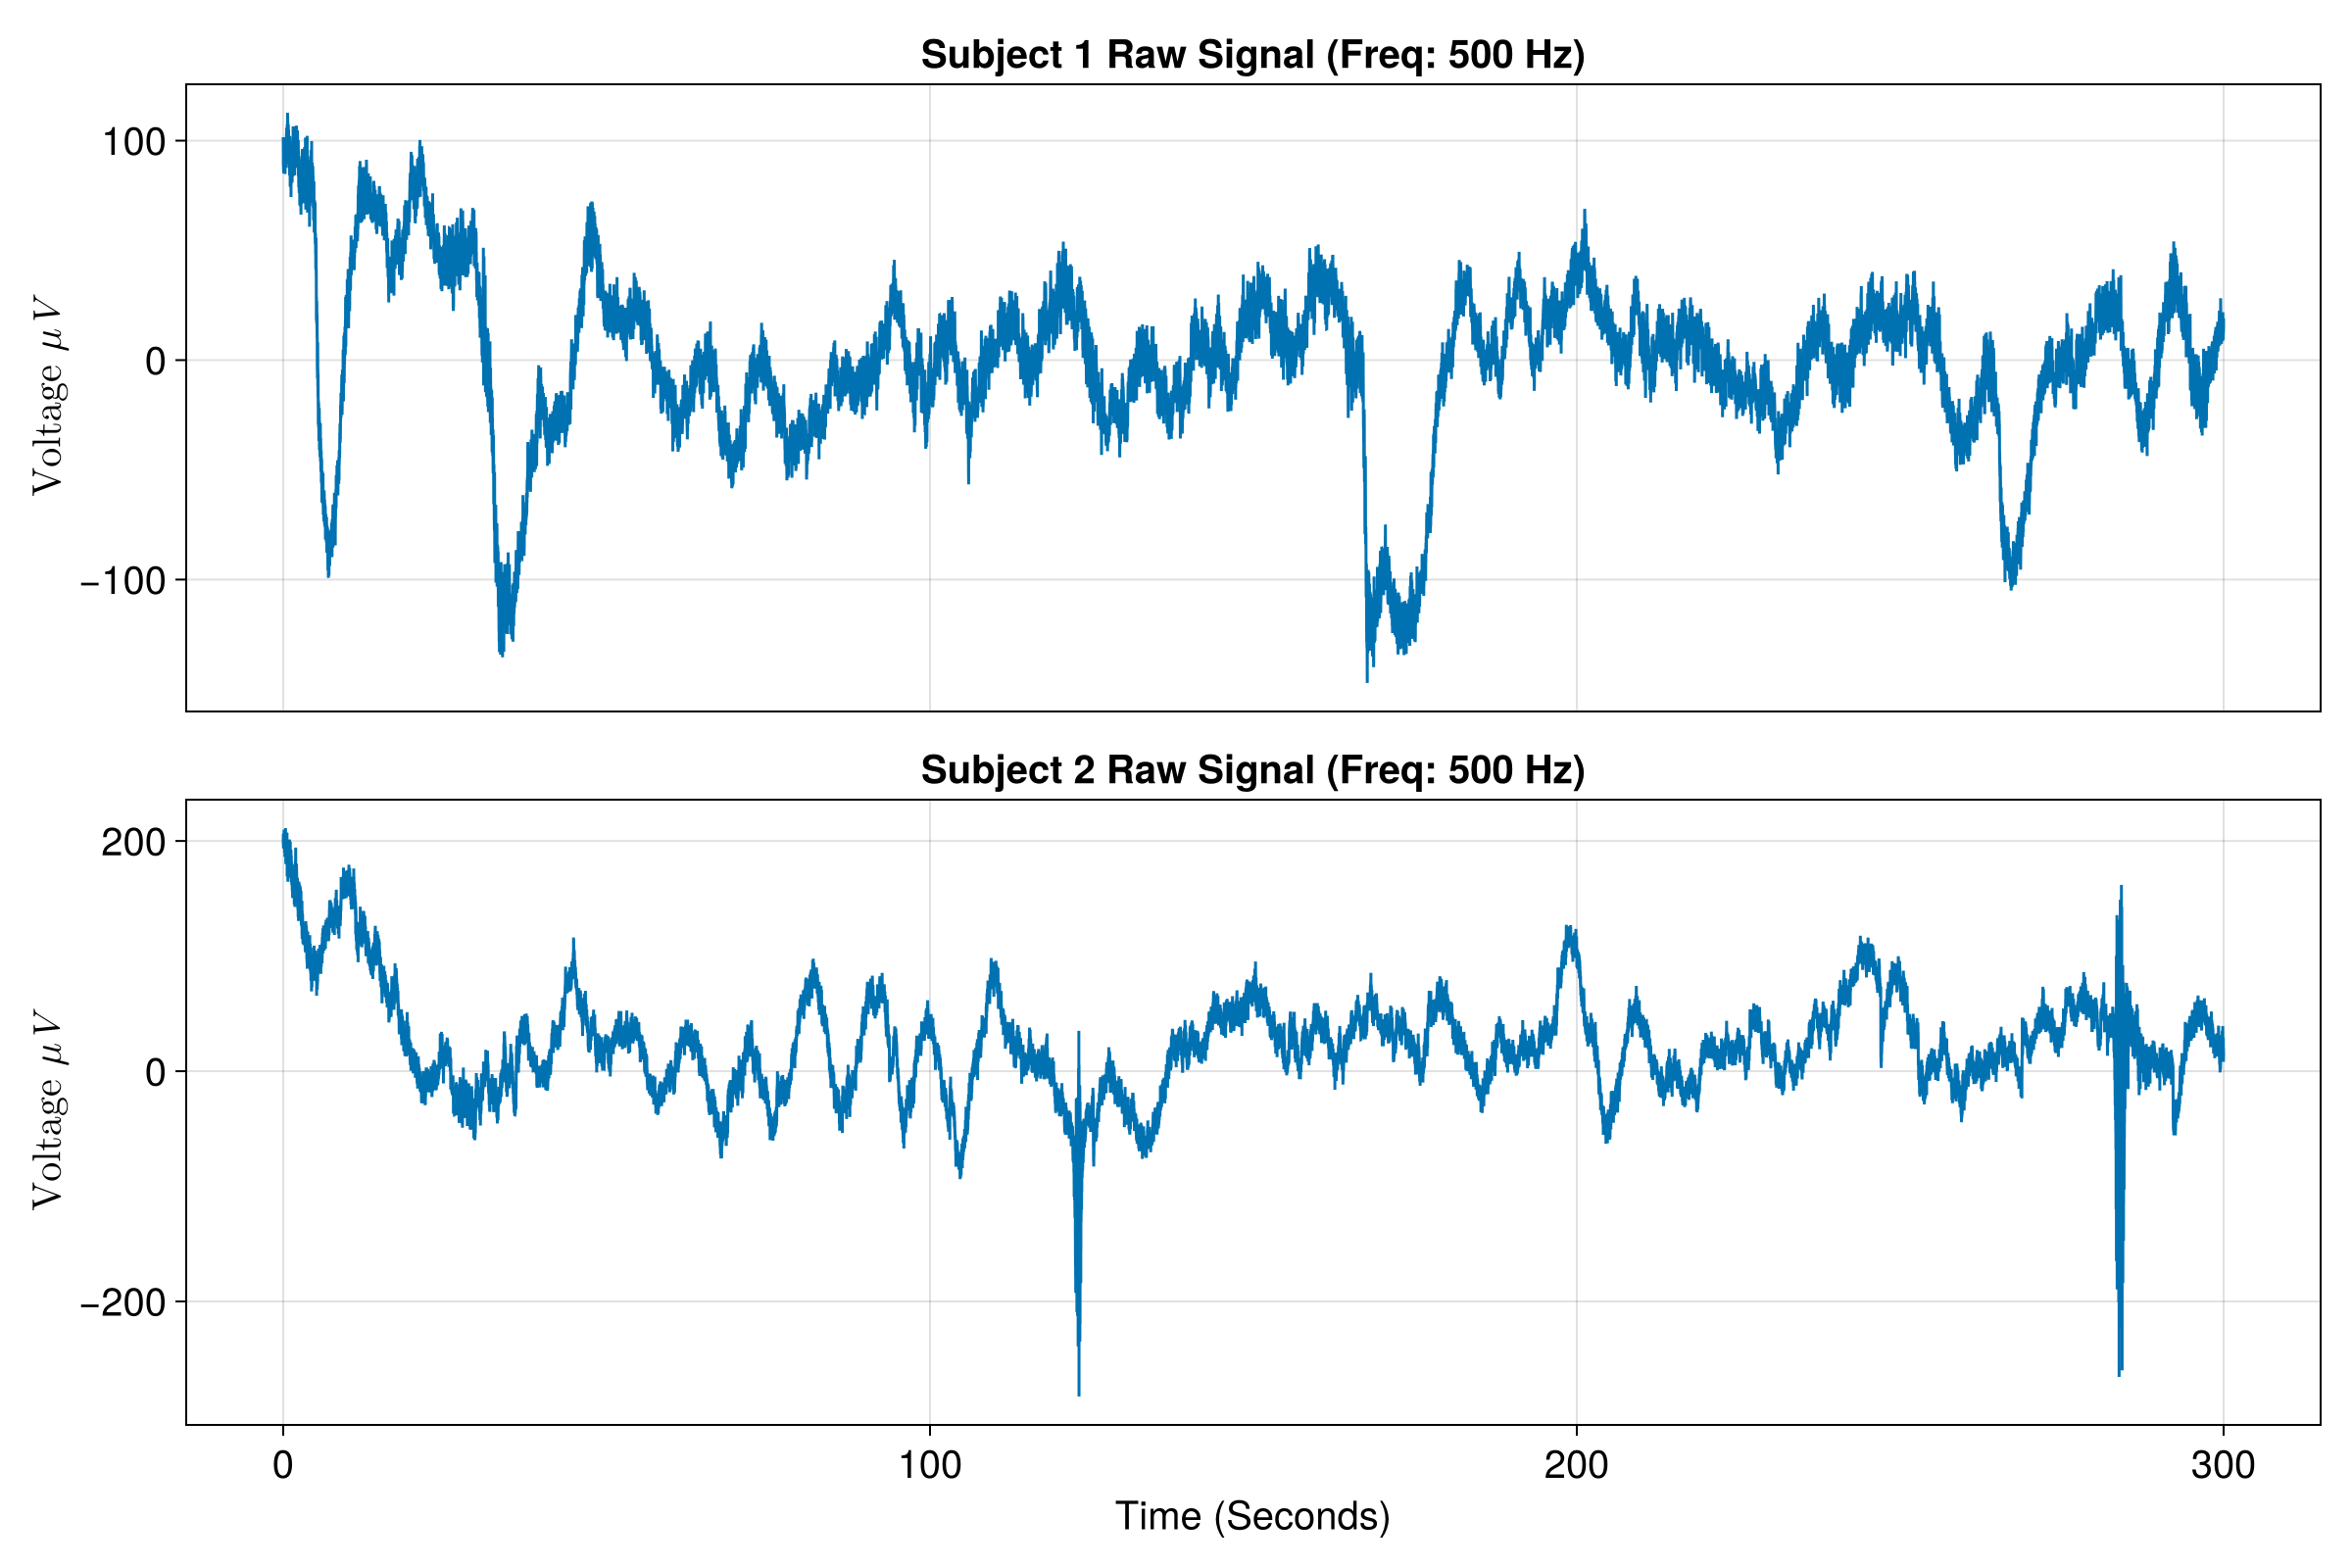

In [7]:
fig = Figure(
        size = (1200, 800), 
        fontsize = 20
);

ax1 = CairoMakie.Axis(
   fig[1, 1], 
)

ax2 = CairoMakie.Axis(
   fig[2, 1], 
)

lines!(ax1, range(0.002, 300; step = 0.002), sub_1_data[1, :])
lines!(ax2, range(0.002, 300; step = 0.002), sub_2_data[1, :])

ax1.xticksvisible = false
ax1.xticklabelsvisible = false

ax1.title = "Subject 1 Raw Signal (Freq: 500 Hz)"
ax2.title = "Subject 2 Raw Signal (Freq: 500 Hz)"

ax2.xlabel = "Time (Seconds)"
ax1.ylabel = L"\text{Voltage } %$\mu V%$"
ax2.ylabel = L"\text{Voltage } %$\mu V%$"

fig

# Displaying Power Bands for Brain Waves

Here, we compute the Welch Periodogram for two subjects at one electrode channel (specifically the channel, "Fp1"):

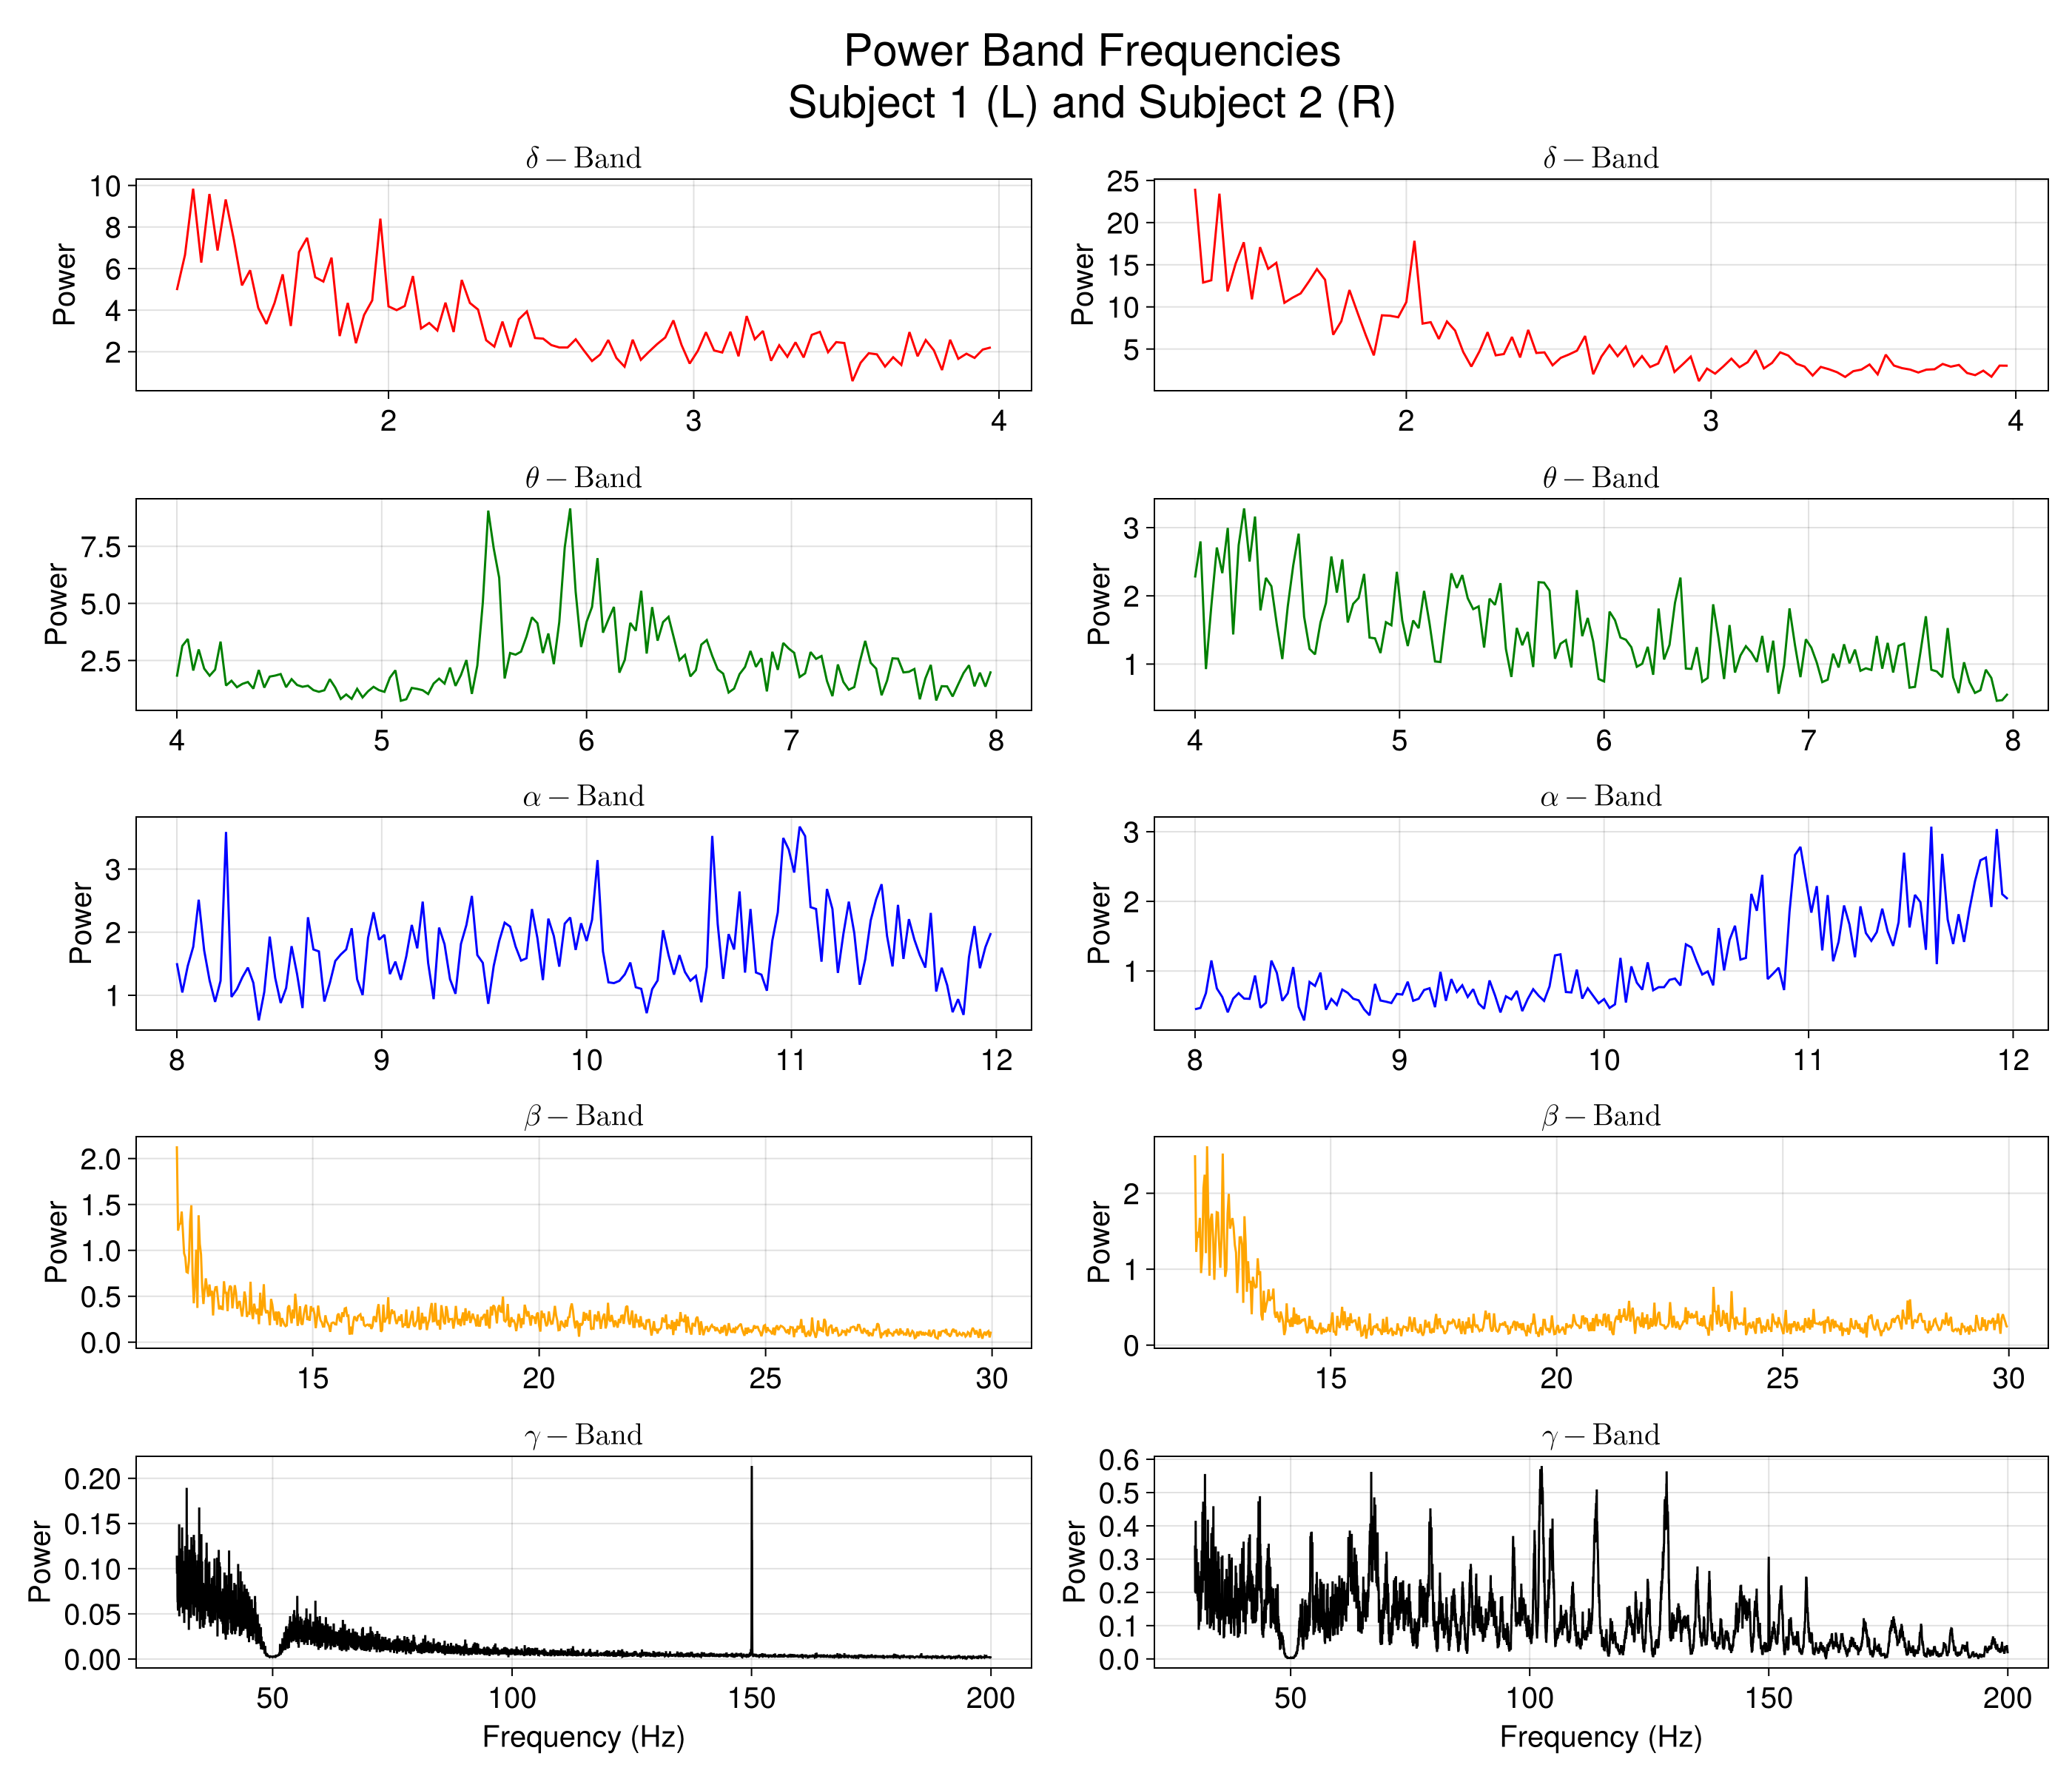

In [8]:
fig = Figure(
   size = (1400, 1200), 
   fontsize = 20,
);

fs = 500 # Sampling Frequency
colors = ["red", "green", "blue", "orange", "black"]
labels = ["delta", "theta", "alpha", "beta", "gamma"]

for (subj_idx, data) in enumerate([sub_1_data, sub_2_data])
    s = welch_pgram(data[1, :], fs=fs)

    f = s.freq
    p = s.power

    delta = findall(x -> x>=0 && x<4, f);
    theta = findall(x -> x>=4 && x<8, f);
    alpha = findall(x -> x>=8 && x<12, f);
    beta = findall(x -> x>=12 && x<30, f);
    gamma = findall(x -> x>=30 && x<200, f);

    bands = [delta[50:end], theta, alpha, beta, gamma]

    for (idx, band) in enumerate(bands)
        ax = CairoMakie.Axis(
          fig[idx, subj_idx], 
        )

        lines!(ax, f[band], p[band], color = colors[idx])
        ax.title = L"\%$(labels[idx])\text{-Band}"
        ax.ylabel = "Power"
        if idx == 5
            ax.xlabel = "Frequency (Hz)"
        end
    end
end

Label(fig[:, :, Top()], "Power Band Frequencies\nSubject 1 (L) and Subject 2 (R)\n\n", fontsize = 30)

fig

# Display Segmented Power Bands for Brain Waves Together

Similar to the last section, we draw the power of the channel data over the recording session altogether but with the brain wave sections with different colors:

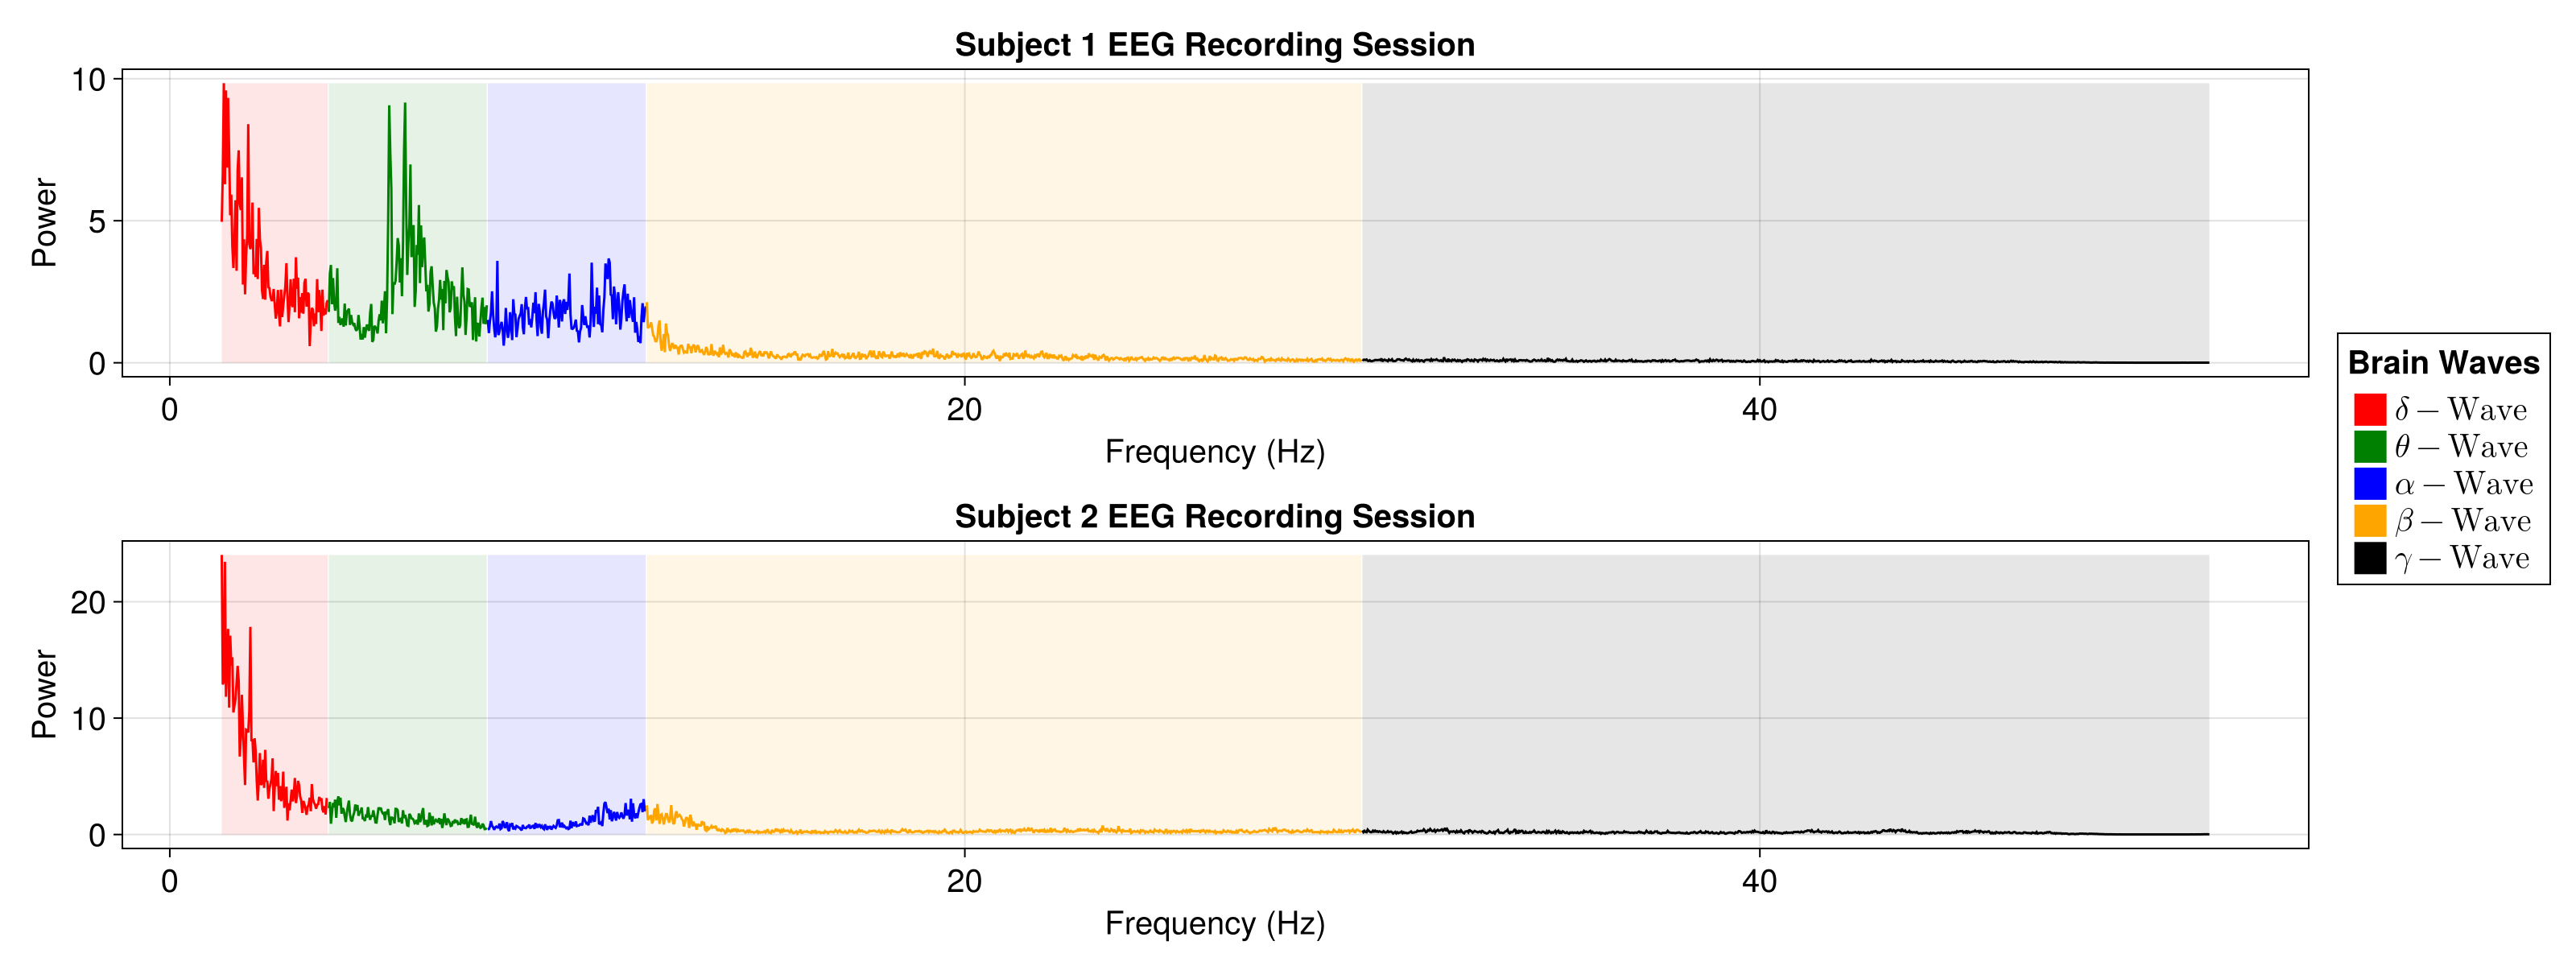

In [9]:
fig = Figure(
   size = (1600, 600), 
   fontsize = 20
);

fs = 500 # Sampling Frequency
colors = ["red", "green", "blue", "orange", "black"]
labels = ["delta", "theta", "alpha", "beta", "gamma"]
legend_elements = [PolyElement(polycolor = colors[i]) for i in 1:length(labels)]

for (subj_idx, data) in enumerate([sub_1_data, sub_2_data])

    ax = CairoMakie.Axis(
      fig[subj_idx, 1], 
    )

    s = welch_pgram(data[1, :], fs=fs)

    f = s.freq
    p = s.power

    delta = findall(x -> x>=0 && x<4, f);
    theta = findall(x -> x>=4 && x<8, f);
    alpha = findall(x -> x>=8 && x<12, f);
    beta = findall(x -> x>=12 && x<30, f);
    gamma = findall(x -> x>=30 && x<200, f);

    bands = [delta[50:end], theta, alpha, beta, gamma[1:800]]
    band_ymax = p[vcat(bands...)] |> maximum

    for (idx, band) in enumerate(bands)

        band!(ax, f[band], fill(0, length(band)), fill(band_ymax, length(band)), color = (colors[idx], 0.1))
        lines!(ax, f[band], p[band], color = colors[idx], label = L"\%$(labels[idx])")
        ax.title = "Subject $(subj_idx) EEG Recording Session"
        ax.ylabel = "Power"
        if idx == 5
            ax.xlabel = "Frequency (Hz)"
        end
    end
end

Legend(fig[:, 2], legend_elements, [L"\%$(l)%$\text{-Wave}" for l in labels], "Brain Waves")

fig

# Display Brain Wave Frequencies over Time

This constructs a digital filter using a Bandpass response and nth-order Butterworth design and segments out each brain wave frequency over time:

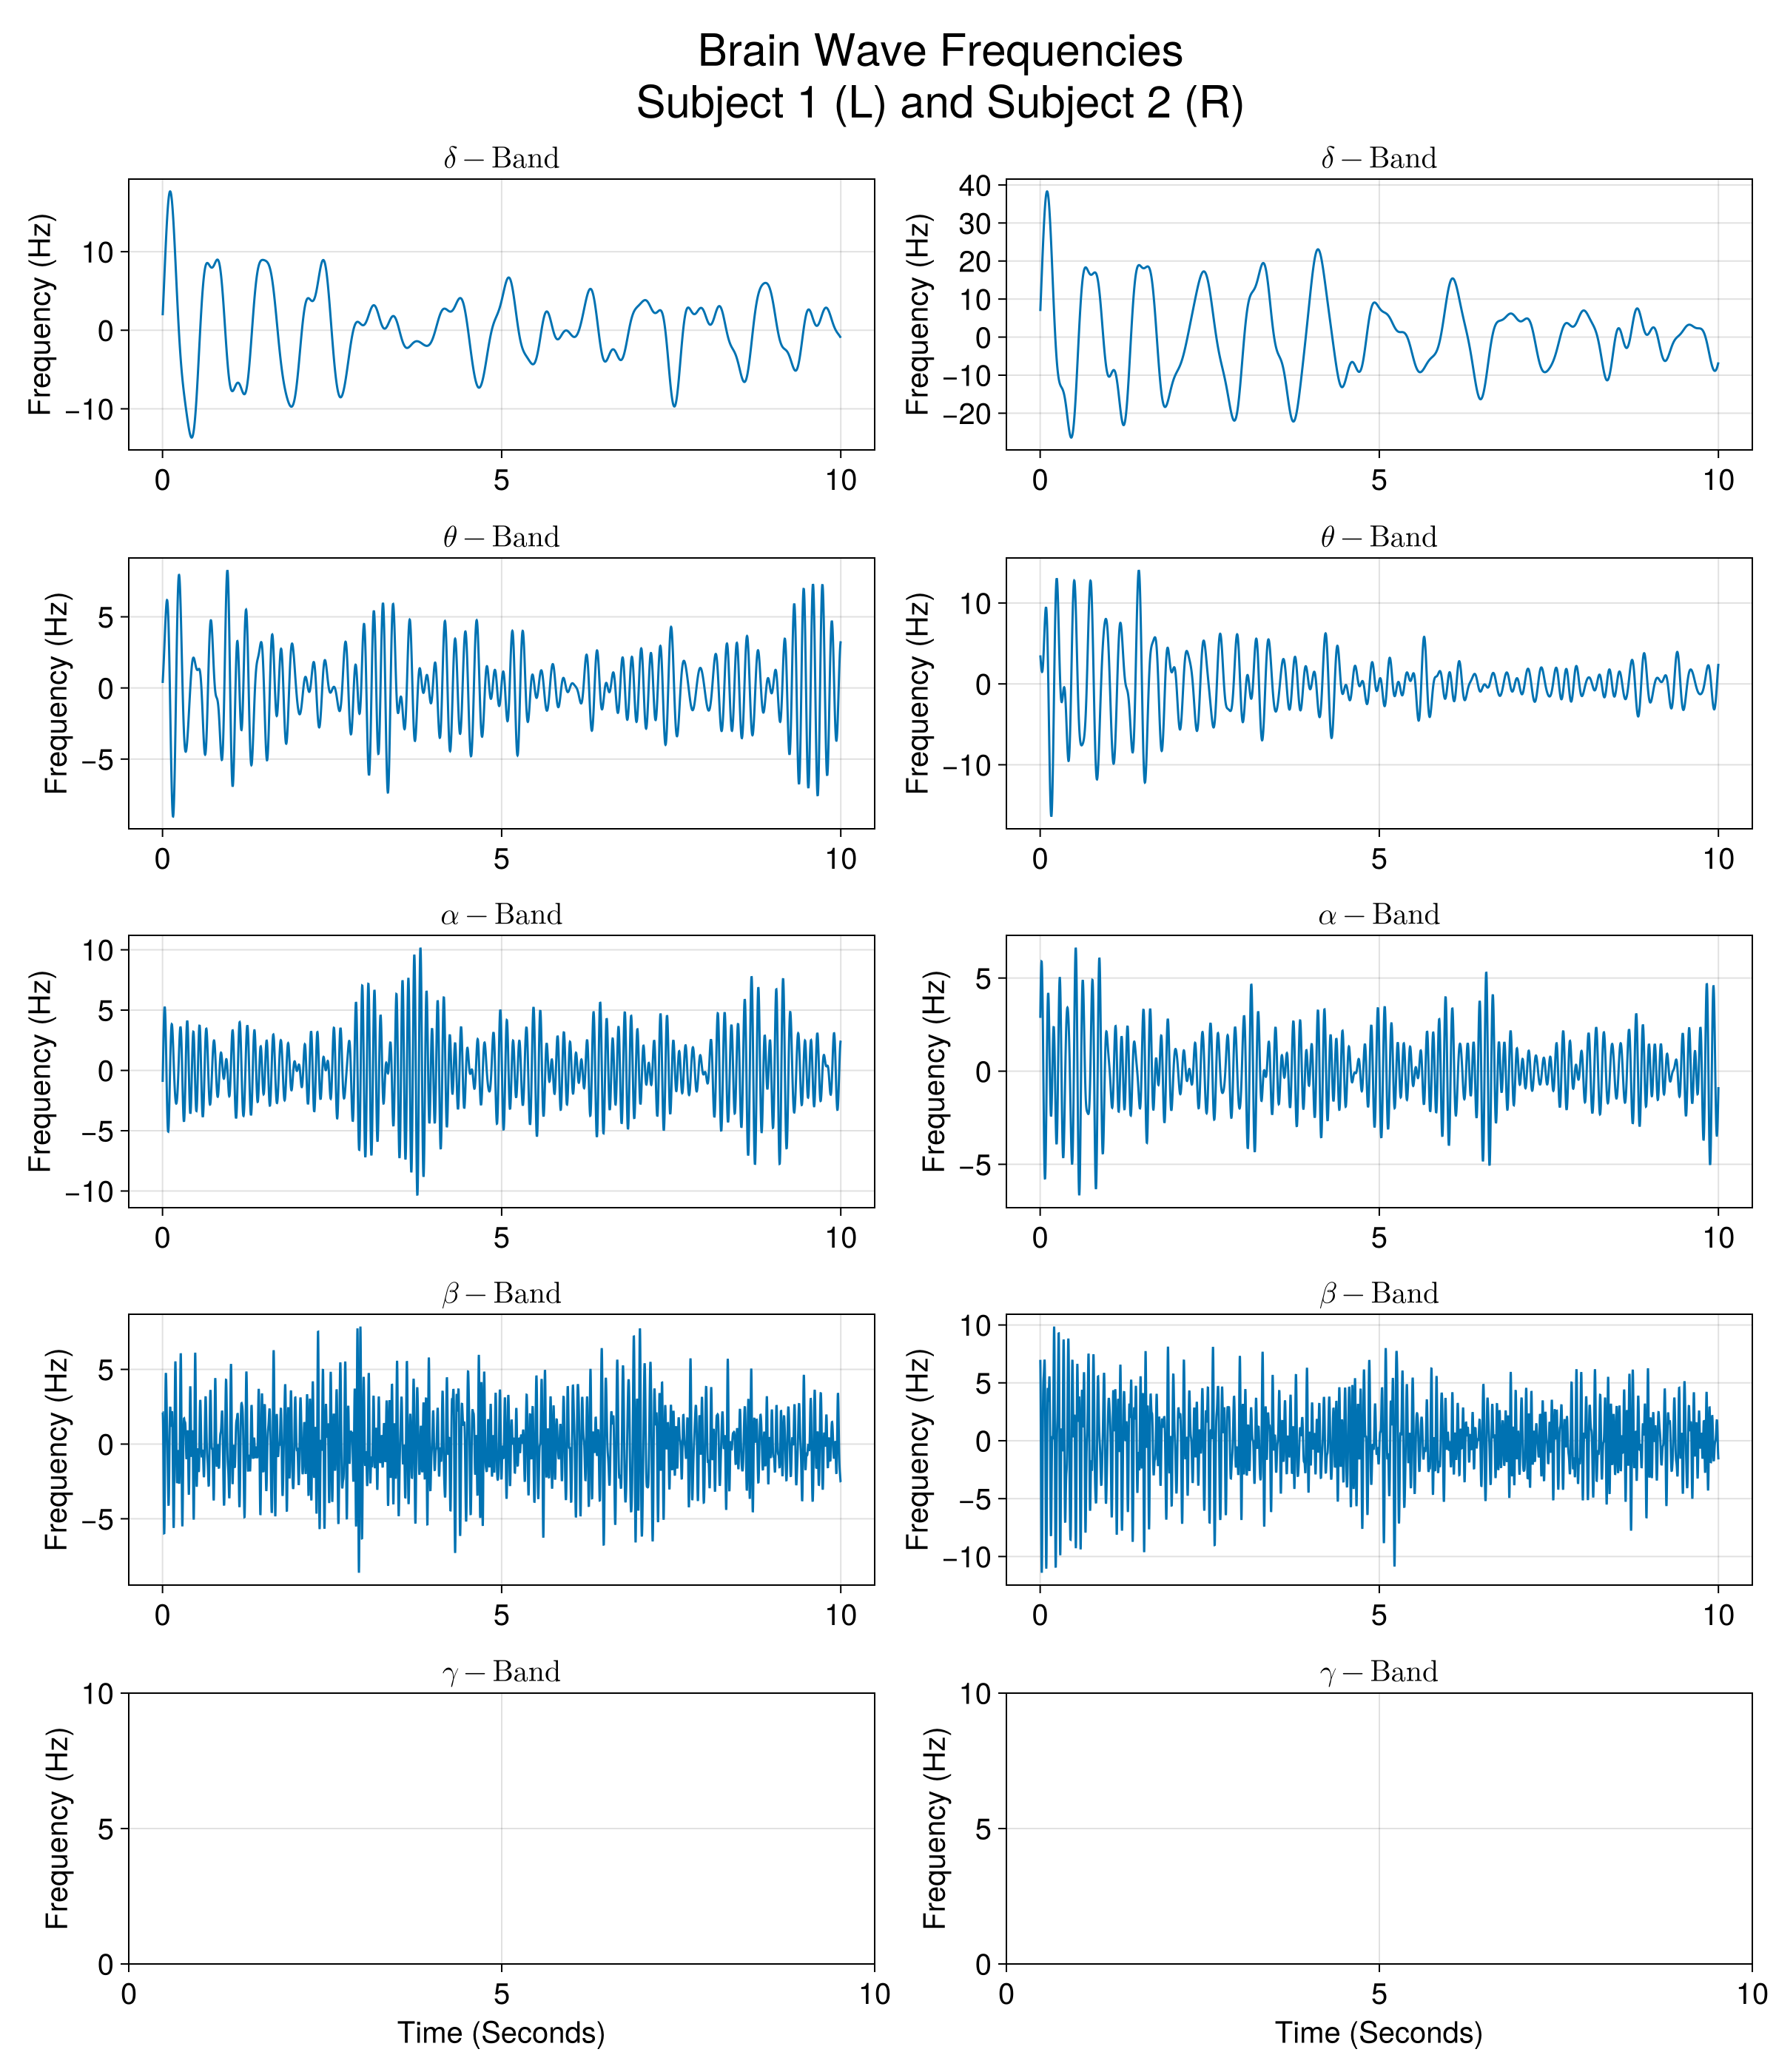

In [10]:
delta_range = [1, 4]
theta_range = [4, 8]
alpha_range = [8, 12]
beta_range = [12, 30]
gamma_range = [30, 200]

fig = Figure(
    size = (1200, 1400), 
    fontsize = 20
);


fs = 500 # Sampling Frequency
for (subj_idx, data) in enumerate([sub_1_data, sub_2_data])

    for (idx, r) in enumerate([delta_range, theta_range, alpha_range, beta_range, gamma_range])
        if r[1] > 0
            Ws = (r[1] - 0.5, r[2] + .5)./(fs/2)
        else
            Ws = (0.5, r[2] + .5)./(fs/2)
        end
        Wp = (r[1], r[2])./(fs/2)
        Rp = 3  # Passband ripple
        Rs = 40 # Stopband attenuation

        n, Wn = buttord(Wp, Ws, Rp, Rs)

        ax = CairoMakie.Axis(
            fig[idx, subj_idx], 
        )

        btr_band_filt = digitalfilter(Bandpass(r[1], r[2]; fs = fs), Butterworth(n))
        signal = filt(btr_band_filt, data[1, :]);

        lines!(ax, range(0.002, 10; step = 0.002), signal[1001:6000]);
        ax.title = L"\%$(labels[idx])\text{-Band}"
        ax.ylabel = "Frequency (Hz)"
        if idx == 5
            ax.xlabel = "Time (Seconds)"
        end
    end
end

Label(fig[:, :, Top()], "Brain Wave Frequencies\nSubject 1 (L) and Subject 2 (R)\n\n", fontsize = 30)

fig